In [ ]:
import os
from google.colab import drive

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.utils.data as data_utils

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import re
import string

from pathlib import Path
import zipfile
from pickle import load

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn import utils

from bisect import bisect_left
from datetime import datetime
import nltk
nltk.download('vader_lexicon')
from nltk import ngrams, FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools
import copy
from math import ceil


SEED = 42
BATCH_SIZE = 128

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
drive.mount('/content/gdrive')

In [ ]:
# Use GPU if available

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}')

In [ ]:
class Columns:
    ID = 'id'
    TIME = 'time'
    TEXT = 'text'
    LIKES = 'likes'
    REACTIONS = 'reactions'
    _TS_ADD = '_ts'
    YEAR = 'year' + _TS_ADD
    MONTH = 'month' + _TS_ADD
    DAY = 'weekday' + _TS_ADD
    HOUR = 'hour' + _TS_ADD
    POST_LEN = 'post_length'
    DISTINCT = 'distinct_words'
    AVG_WRD = 'avg_wrd_len'
    MAX_WRD = 'max_wrd_len'
    MIN_WRD = 'min_wrd_len'
    NGRAMS = 'ngrams'
    NUMBERS = 'numbers'
    EX_MARKS = 'exclamation'

In [ ]:
def k_most_common_ngrams(X, ng=2, k=20):
    """
    Return most K common trigrams in the files in the input directory.
    """
    top_k = FreqDist(ngrams('\n'.join(X).split(), ng))
    return [' '.join(t[0]) for t in top_k.most_common(k)]


def k_most_common_char_ngrams(X, ng=2, k=20):
    """
    Return most K common trigrams in the files in the input directory.
    """
    top_k = FreqDist(ngrams('\n'.join(X), ng))
    return [' '.join(t[0]) for t in top_k.most_common(k)]


def get_most_common_k(X, k=50):
    counter = Counter(" ".join(X.apply(lambda s: re.sub(f'[{string.punctuation}]', '', s).strip())).split())
    return sorted(counter, key=counter.get, reverse=True)[:k]


def get_best_k(X, y, k=20):
    # Crete TF-IDF values based on the training data
    vectorizer = TfidfVectorizer(use_idf=True)
    # vectorizer = CountVectorizer()
    tfidf_vals = vectorizer.fit_transform(X)

    # create and fit selector
    selector = SelectKBest(k=k)
    selector.fit(tfidf_vals.toarray(), y)
    words_idx = selector.get_support(indices=True)

    # get the actual words
    the_words = [k for k,v in vectorizer.vocabulary_.items() if v in words_idx]

    return the_words


def my_train_test_split(df, label_col_name, test_percentage, shuffle=False):
    df2 = df.copy()
    if shuffle:
        df2 = df2.sample(frac=1).reset_index(drop=True)

    data_cols = [c for c, col in enumerate(df2.columns) if col != label_col_name]
    train_size = int(df2.shape[0] * (1 - test_percentage))

    X_train = df2.iloc[:train_size, data_cols]
    y_train = df2.iloc[:train_size][label_col_name]
    X_test = df2.iloc[train_size:, data_cols].reset_index(drop=True)
    y_test = df2.iloc[train_size:][label_col_name].reset_index(drop=True)

    return X_train, X_test, y_train, y_test

In [ ]:
def plot_graphs(train_acc_lst, val_acc_lst, train_loss_lst, val_loss_lst):
    plt.figure(figsize=(30, 10))

    # accuracy
    plt.subplot(2,4,1)
    plt.ylim(0, 1.1)
    plt.plot(range(len(train_acc_lst)), train_acc_lst)
    plt.plot(range(len(val_acc_lst)), val_acc_lst)
    plt.legend(['training acc', 'val acc'])

    # loss
    plt.subplot(2,4,2)
    plt.ylim(0, max(1, max(train_loss_lst + val_loss_lst)) + 0.1 )
    plt.plot(range(len(train_loss_lst)), train_loss_lst)
    plt.plot(range(len(val_loss_lst)), val_loss_lst)
    plt.legend(['training loss', 'val loss'])

    plt.show()

In [ ]:
# Load data

ROOT_DATA_DIR = Path("/content/gdrive/MyDrive/confessions-project/")
DATA_CSV = ROOT_DATA_DIR / '2021-06-05 09-33-47  12986 posts preprocessed.csv'

df = pd.read_csv(DATA_CSV)

# create target
TARGET = LABEL = 'popular'
df[TARGET] = df[Columns.LIKES] >= 9

# drop unused columns
df.drop([Columns.REACTIONS, Columns.LIKES], axis=1, inplace=True)

# shuffle
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# convert time string to datetime
df[Columns.TIME] = df[Columns.TIME].apply(pd.to_datetime)

# Feature Engineering

## Datetime

In [ ]:
for unit in ['year', 'month', 'hour']:
    df[unit + Columns._TS_ADD] = df[Columns.TIME].apply(lambda t: getattr(t, unit))
df[Columns.DAY] = df[Columns.TIME].apply(lambda t: t.weekday())

## Stats

In [ ]:
df[Columns.POST_LEN] = df[Columns.TEXT].apply(lambda s: len(s.split()))
df[Columns.DISTINCT] = df[Columns.TEXT].apply(lambda s: len(set(s.split())))
df[Columns.AVG_WRD] = df[Columns.TEXT].apply(lambda s: np.mean([len(w) for w in s.split()]))
df[Columns.MAX_WRD] = df[Columns.TEXT].apply(lambda s: np.max([len(w) for w in s.split()]))
df[Columns.MIN_WRD] = df[Columns.TEXT].apply(lambda s: np.min([len(w) for w in s.split()]))
df[Columns.NUMBERS] = df[Columns.TEXT].apply(lambda s: len(re.findall(r'\d+', s)))
df[Columns.EX_MARKS] = df[Columns.TEXT].apply(lambda s: max([0] + [len(x) for x in re.findall(r'!+', s)]))

## Sentiment analysis

In [ ]:
sia = SentimentIntensityAnalyzer()
sentiments = pd.DataFrame(df[Columns.TEXT].apply(sia.polarity_scores).tolist())
df = pd.concat([df, sentiments], axis=1)

## More trainable features

In [ ]:
ftr_words = set()

In [ ]:
# split to train / test
X_train, X_test, y_train, y_test = my_train_test_split(df, LABEL, 0.15)

In [ ]:
# get best k words for classification
best_k_words = get_best_k(X_train[Columns.TEXT], y_train, k=20)
ftr_words.update(best_k_words)

In [ ]:
# get most common words
most_common_words = get_most_common_k(X_train[Columns.TEXT], k=20)
ftr_words.update(most_common_words)

In [ ]:
# get word / char ngrams
ng = 2
ngrams_voc = k_most_common_ngrams(X_train[Columns.TEXT], ng=ng, k=20)
ftr_words.update(ngrams_voc)
ch_ng = 3
ch_ngrams_voc = k_most_common_char_ngrams(X_train[Columns.TEXT], ng=ch_ng, k=20)
ftr_words.update(ch_ngrams_voc)

In [ ]:
# custom words
custom_words = []
ftr_words.update(custom_words)

In [ ]:
ftr_words = list(ftr_words)

## Finalize features

In [ ]:
vectorizer = TfidfVectorizer(vocabulary=list(ftr_words),
                                use_idf=True,
                                ngram_range=(1, max(ng, ch_ng)))
tfidf = vectorizer.fit_transform(X_train[Columns.TEXT])
X_train = pd.concat([X_train, pd.DataFrame(tfidf.toarray(), columns=ftr_words)], axis=1)
tfidf = vectorizer.transform(X_test[Columns.TEXT])
X_test = pd.concat([X_test, pd.DataFrame(tfidf.toarray(), columns=ftr_words)], axis=1)

features = [Columns.YEAR, Columns.MONTH, Columns.DAY, Columns.HOUR, Columns.POST_LEN, Columns.DISTINCT,
            Columns.AVG_WRD, Columns.MAX_WRD, Columns.MIN_WRD, Columns.NUMBERS, Columns.EX_MARKS]

# scale features
scaler = MinMaxScaler()
X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

features += ftr_words + sentiments.columns.tolist()

In [ ]:
class MyDataset(Dataset):
    def __init__(self, X, y):

        self.labels = y.tolist()
        self.sequences = X.values
        
    def __getitem__(self, i):
        return self.sequences[i, :], self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [ ]:
def collate_fn(batch):
    inputs = torch.FloatTensor([item[0] for item in batch])
    target = torch.LongTensor([item[1] for item in batch])
    return inputs, target

training_ds = MyDataset(X_train[features], y_train)
test_ds = MyDataset(X_test[features], y_test)

training_ldr = DataLoader(training_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
test_ldr = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

# Classification

## Model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = 128
        self.num_layers = 1
        self.rnn = nn.LSTM(input_size, self.hidden_size, self.num_layers, batch_first=True)
        seq_length = 1
        self.fc = nn.Linear(self.hidden_size * seq_length, num_classes)
    
    def init_hidden(self, input_size):
        return torch.randn(self.num_layers, input_size, self.hidden_size).to(device)

    def forward(self, x):
        h0 = self.init_hidden(x.size(0))
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.rnn(x, (h0, c0))
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

model = LSTM(len(features), 2)
model.to(device)
print(model)

LSTM(
  (rnn): LSTM(93, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [ ]:
class FC(nn.Module):
    def __init__(self, in_features, num_classes):
        super(FC, self).__init__()
        self.fc1 = nn.Linear(in_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x.squeeze(1).float()))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.softmax(self.fc4(x))

# model = FC(len(features), 2)
# model.to(device)
# print(model)

FC(
  (fc1): Linear(in_features=93, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
)


## Train

In [ ]:
def train(model, training_loader, test_loader, lr, epochs):
    # criterion = nn.BCEWithLogitsLoss()  # From PyTorch: This loss combines a Sigmoid layer and the BCELoss in one single class.
                                        # This version is more numerically stable than using a plain Sigmoid followed by a BCELoss.

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=0.001)  # TODO: Try
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=lr)
    # scheduler = MultiStepLR(optimizer, milestones=[25,50,75], gamma=0.10)

    model.train(mode=True)  # Put model in training mode
    train_losses, train_acc = [], []
    val_losses, val_acc = [], []
    for epoch in range(epochs):
        progress_bar = tqdm(training_loader, leave=False)
        currnet_train_losses, current_train_acc = [], []

        if epoch == 10:
            print('decreasing learning rate...')
            for g in optimizer.param_groups:
                g['lr'] /= 10

        if epoch == 20:
            print('decreasing learning rate...')
            for g in optimizer.param_groups:
                g['lr'] /= 10

        for data, labels in progress_bar:
            data, labels = data.to(device), labels.to(device)
            data = data.unsqueeze(1)
            # print(np.unique(labels.cpu().numpy(), return_counts=True))

            model.zero_grad()

            output = model(data)
            # loss = criterion(output.squeeze(), labels.float())
            loss = criterion(output, labels)
            
            loss.backward()
                
            nn.utils.clip_grad_norm_(model.parameters(), 3)  # ??

            optimizer.step()
            # scheduler.step()
            
            progress_bar.set_description(f'Training Loss: {loss.item():.3f}')
            
            currnet_train_losses.append(loss.item())

            # predictions = torch.sigmoid(output.squeeze().data)
            # predictions = np.array([p > 0.5 for p in predictions])
            predictions = output.argmax(dim=1).cpu().numpy()
            # print(f'labels = {labels.cpu()}')
            # print(f'predictions = {predictions}')
            acc = (predictions == labels.cpu().numpy()).mean()
            current_train_acc.append(acc)
        
        epoch_loss = np.average(currnet_train_losses)
        train_losses.append(epoch_loss)

        epoch_acc = np.average(current_train_acc)
        train_acc.append(epoch_acc)

        ###################################################
        # predict validation data, but first disable gradient tracking, and enter evaluation mode
        model.train(mode=False)  # enter eval mode
        with torch.no_grad():  # locally disable gradient tracking
            current_val_losses, current_val_acc = [], []
            progress_bar_val = tqdm(test_loader, leave=False)
            for val_data, val_labels in progress_bar_val:
                val_data, val_labels = val_data.to(device), val_labels.to(device)
                val_data = val_data.unsqueeze(1)
                # print(np.unique(val_labels.cpu().numpy(), return_counts=True))
                
                val_output = model(val_data)
                # val_loss = criterion(val_output.squeeze(), val_labels.float())
                val_loss = criterion(val_output, val_labels)

                progress_bar_val.set_description(f'Val Loss: {loss.item():.3f}')

                current_val_losses.append(val_loss.item())

                # val_preds = torch.sigmoid(val_output.squeeze().data)
                # val_preds = np.array([p > 0.5 for p in val_preds])
                val_preds = val_output.argmax(dim=1).cpu().numpy()
                acc = (val_preds == val_labels.cpu().numpy()).mean()
                current_val_acc.append(acc)
            
            epoch_loss_val = np.average(current_val_losses)
            val_losses.append(epoch_loss_val)

            epoch_acc_val = np.average(current_val_acc)
            val_acc.append(epoch_acc_val)
        model.train(mode=True)  # exit eval mode, re-enter training mode
        ###################################################
            
        tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}\tValidation Loss: {epoch_loss_val:.3f}\tTrain Acc:{epoch_acc:.2f}\tValidation Acc:{epoch_acc_val:.2f}')
    
    return train_acc, val_acc, train_losses, val_losses

In [ ]:
train_acc_lst, val_acc_lst, train_loss_lst, val_loss_lst = train(model, training_ldr, test_ldr, lr=0.0001, epochs=30)

Epoch #1	Train Loss: 0.694	Validation Loss: 0.695	Train Acc:0.50	Validation Acc:0.50


Epoch #2	Train Loss: 0.693	Validation Loss: 0.692	Train Acc:0.51	Validation Acc:0.52


Epoch #3	Train Loss: 0.692	Validation Loss: 0.692	Train Acc:0.52	Validation Acc:0.53


Epoch #4	Train Loss: 0.691	Validation Loss: 0.691	Train Acc:0.52	Validation Acc:0.52


Epoch #5	Train Loss: 0.690	Validation Loss: 0.692	Train Acc:0.53	Validation Acc:0.52


Epoch #6	Train Loss: 0.689	Validation Loss: 0.689	Train Acc:0.54	Validation Acc:0.56


Epoch #7	Train Loss: 0.689	Validation Loss: 0.690	Train Acc:0.54	Validation Acc:0.54


Epoch #8	Train Loss: 0.688	Validation Loss: 0.689	Train Acc:0.55	Validation Acc:0.54


Epoch #9	Train Loss: 0.687	Validation Loss: 0.689	Train Acc:0.56	Validation Acc:0.54


Epoch #10	Train Loss: 0.686	Validation Loss: 0.688	Train Acc:0.56	Validation Acc:0.56


decreasing learning rate...


Epoch #11	Train Loss: 0.686	Validation Loss: 0.689	Train Acc:0.56	Validation Acc:0.54


Epoch #12	Train Loss: 0.685	Validation Loss: 0.687	Train Acc:0.57	Validation Acc:0.54


Epoch #13	Train Loss: 0.685	Validation Loss: 0.686	Train Acc:0.56	Validation Acc:0.56


Epoch #14	Train Loss: 0.686	Validation Loss: 0.687	Train Acc:0.56	Validation Acc:0.55


Epoch #15	Train Loss: 0.685	Validation Loss: 0.687	Train Acc:0.57	Validation Acc:0.55


Epoch #16	Train Loss: 0.685	Validation Loss: 0.687	Train Acc:0.56	Validation Acc:0.56


Epoch #17	Train Loss: 0.685	Validation Loss: 0.687	Train Acc:0.57	Validation Acc:0.55


Epoch #18	Train Loss: 0.685	Validation Loss: 0.684	Train Acc:0.56	Validation Acc:0.56


Epoch #19	Train Loss: 0.685	Validation Loss: 0.688	Train Acc:0.57	Validation Acc:0.54


Epoch #20	Train Loss: 0.685	Validation Loss: 0.685	Train Acc:0.57	Validation Acc:0.56


decreasing learning rate...


Epoch #21	Train Loss: 0.684	Validation Loss: 0.687	Train Acc:0.57	Validation Acc:0.56


Epoch #22	Train Loss: 0.684	Validation Loss: 0.686	Train Acc:0.57	Validation Acc:0.57


Epoch #23	Train Loss: 0.685	Validation Loss: 0.686	Train Acc:0.57	Validation Acc:0.56


Epoch #24	Train Loss: 0.684	Validation Loss: 0.687	Train Acc:0.56	Validation Acc:0.55


Epoch #25	Train Loss: 0.685	Validation Loss: 0.687	Train Acc:0.57	Validation Acc:0.55


Epoch #26	Train Loss: 0.685	Validation Loss: 0.687	Train Acc:0.56	Validation Acc:0.55


Epoch #27	Train Loss: 0.684	Validation Loss: 0.686	Train Acc:0.57	Validation Acc:0.57


Epoch #28	Train Loss: 0.684	Validation Loss: 0.687	Train Acc:0.56	Validation Acc:0.56


Epoch #29	Train Loss: 0.684	Validation Loss: 0.687	Train Acc:0.57	Validation Acc:0.53


Epoch #30	Train Loss: 0.684	Validation Loss: 0.686	Train Acc:0.57	Validation Acc:0.57


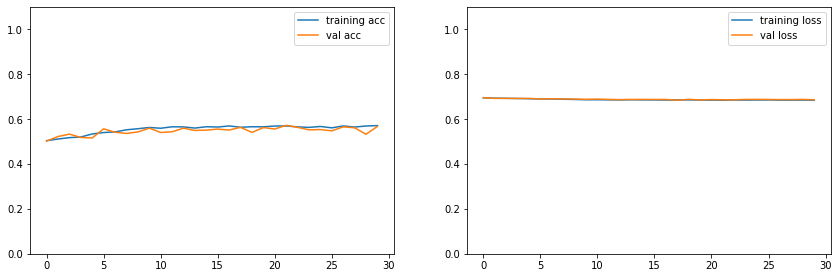

In [ ]:
plot_graphs(train_acc_lst, val_acc_lst, train_loss_lst, val_loss_lst)